## Import

In [89]:
import random
import pandas as pd
pd.options.mode.chained_assignment = None
import umap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from recoxplainer.config import cfg
from recoxplainer.data_reader.data_reader import DataReader
from recoxplainer.models.emf_model import EMFModel
from recoxplainer.models.mlp_model import MLPModel
from recoxplainer.models import ALS, GMFModel, PyTorchModel, BPR
from recoxplainer.recommender import Recommender 
from recoxplainer.evaluator import Splitter, Evaluator, ExplanationEvaluator
from recoxplainer.explain import EMFExplainer

## Import data

In [2]:
data = DataReader(**cfg.ml100k)
data.make_consecutive_ids_in_dataset()
sp = Splitter()
train, test = sp.split_leave_n_out(data, frac=0.1)

## Model training & recommending

In [90]:
mlp = MLPModel(**cfg.model.mlp)
mlp.fit(train)

  0%|          | 0/30 [00:00<?, ?it/s]

True

In [91]:
rec = Recommender(train, mlp)
rec = rec.recommend_all()

Recommending for users:   0%|          | 0/943 [00:00<?, ?it/s]

In [92]:
rec

,userId,itemId,rank
1433,0.0,1471.0,1.0
91,0.0,96.0,2.0
15,0.0,17.0,3.0
184,0.0,190.0,4.0
1391,0.0,1429.0,5.0
...,...,...,...
536,942.0,551.0,6.0
276,942.0,289.0,7.0
1235,942.0,1257.0,8.0
496,942.0,511.0,9.0


## Generating Explanations

In [93]:
explanations = EMFExplainer(mlp, rec, data)

In [94]:
res = explanations.explain_recommendations()

Computing explanations:   0%|          | 0/9430 [00:00<?, ?it/s]

ModuleAttributeError: 'MLPModel' object has no attribute 'sim_users'

In [75]:
res.head(20)

,userId,itemId,rank,explanations
1218,0.0,1255.0,1.0,{}
1202,0.0,1239.0,2.0,{}
194,0.0,200.0,3.0,{5: 1}
183,0.0,189.0,4.0,"{2: 1, 4: 3, 5: 1}"
169,0.0,174.0,5.0,{}
688,0.0,719.0,6.0,{2: 2}
125,0.0,130.0,7.0,{}
462,0.0,482.0,8.0,{}
628,0.0,657.0,9.0,{3: 1}
232,0.0,239.0,10.0,{5: 3}


In [76]:
ex = ExplanationEvaluator(train.num_user)

Evaluationg an explanation:

In [77]:
ex.mean_explaianable_precision(res, emf.explainability_matrix)

0.48716861081654367

In [78]:
ex.model_fidelity(res)

0.5038176033934259

In [15]:
def plot_model(model, dt, user_X):
    
    dim_red_model = umap.UMAP().fit_transform(model.item_embedding())
    dim_red_model_usr = umap.UMAP().fit_transform(model.user_embedding())

    rated_items = dt.dataset[dt.dataset.userId == user_X].itemId

    item_emb_for_user_X = pd.DataFrame.from_dict({
        'x': dim_red_model[:,0],
        'y': dim_red_model[:,1],
        'expl': model.explainability_matrix[user_X, :]})

    item_emb_for_user_X = item_emb_for_user_X.sort_values(by=['expl'])

    sns.scatterplot(data=item_emb_for_user_X, x="x", y="y", hue="expl")
    
    plt.scatter(dim_red_model[rated_items,0], 
            dim_red_model[rated_items,1], 
            marker='o', c='#c3e0f4')

    plt.scatter(dim_red_model_usr[user_X,0], 
            dim_red_model_usr[user_X,1], 
            marker='X', s=100, c='#419ede')

In [16]:
rand_usr = random.choice(data.dataset.userId.unique())

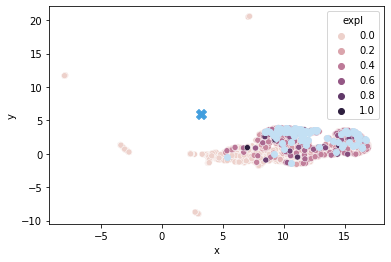

In [17]:
plot_model(emf, train, rand_usr)